In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [21]:
# Data loading, the full dataset from Retailrocket has been added to the dataset folder on the main root of the project's codebase.
df_events = pd.read_csv('../dataset/events.csv')
df_properties = pd.concat([pd.read_csv('../dataset/item_properties_part1.csv'), pd.read_csv('../dataset/item_properties_part2.csv')])
df_categories = pd.read_csv('../dataset/category_tree.csv')

In [22]:
# Display basic information (shape and column details) for key DataFrames 
# to verify their structure and ensure data has been loaded correctly.

print("--- Inspecting df_events ---")
print(f"Shape: {df_events.shape}")
print("\nInfo:")
display(df_events.info())

print("\n\n--- Inspecting df_properties ---")
print(f"Shape: {df_properties.shape}")
print("\nInfo:")
display(df_properties.info())

print("\n\n--- Inspecting df_categories ---")
print(f"Shape: {df_categories.shape}")
print("\nInfo:")
display(df_categories.info())

--- Inspecting df_events ---
Shape: (2756101, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


None



--- Inspecting df_properties ---
Shape: (20275902, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


None



--- Inspecting df_categories ---
Shape: (1669, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


None

## Types and Features

The datasets use a combination of integer, float, and object data types, each specific to its file. In events.csv, timestamp, visitorid, and itemid are int64, transactionid is float64 to allow for missing values, and event is an object representing categorical interaction types. In item_properties.csv, timestamp and itemid are int64, while property and value are object types, storing categorical or hashed text and numerical values. In category_tree.csv, categoryid is int64, and parentid is float64 to accommodate missing entries in the hierarchy. This combination of data types enables the datasets to capture numerical, categorical, and temporal information across user behaviour, item attributes, and category structure.

## Line grapgh and bubble graph

Line Graphs: detect peak activity days, monthly trends, and visitor engagement.

Bubble Charts: identify popular items, high-converting items, price sensitivity, and category-level popularity.

In [23]:
sns.set(style="whitegrid")

# Convert event timestamps to datetime
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit='ms')

# Extract date and month for aggregation
df_events['date'] = df_events['timestamp'].dt.date
df_events['month'] = df_events['timestamp'].dt.to_period('M')


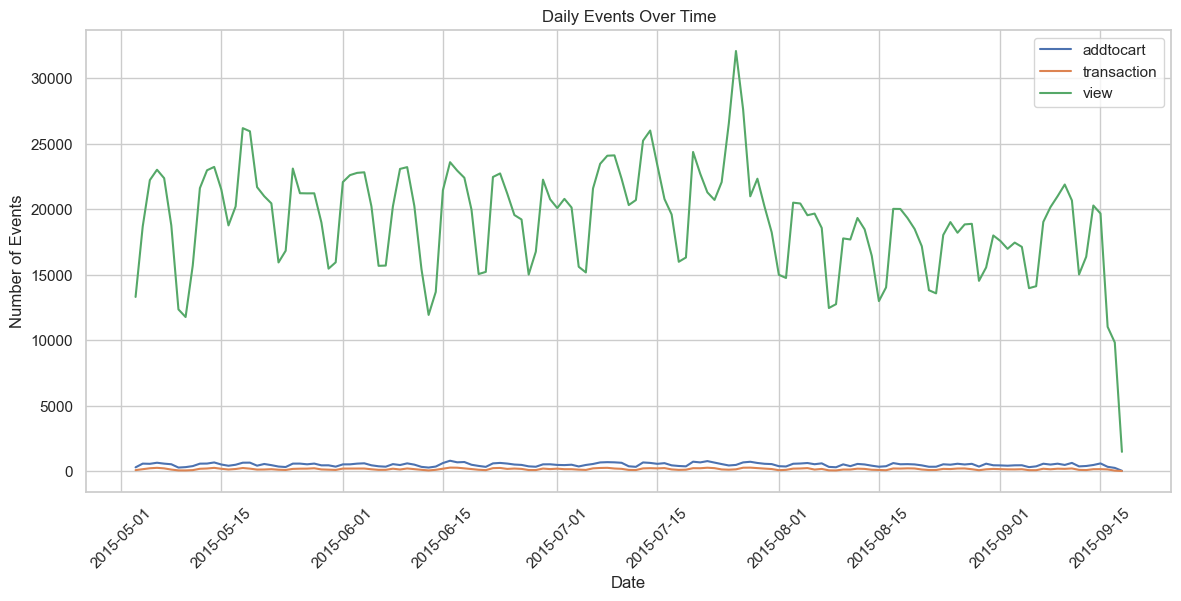

In [24]:
daily_events = df_events.groupby(['date','event']).size().unstack(fill_value=0)

plt.figure(figsize=(14,6))
for event_type in daily_events.columns:
    plt.plot(daily_events.index, daily_events[event_type], label=event_type)
plt.title("Daily Events Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.legend()
plt.xticks(rotation=45)
plt.show()


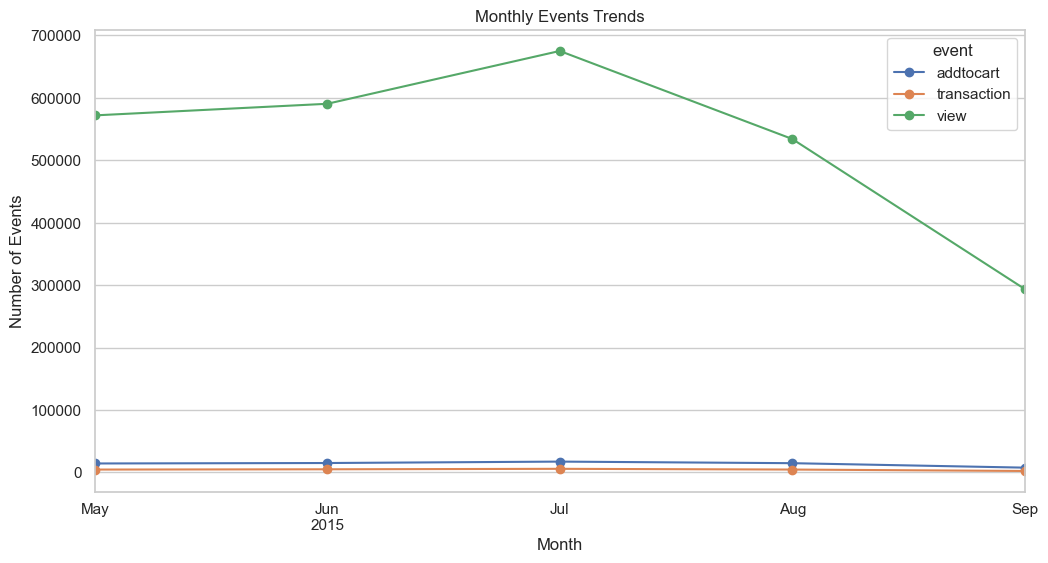

In [25]:
monthly_events = df_events.groupby(['month','event']).size().unstack(fill_value=0)

monthly_events.plot(kind='line', marker='o', figsize=(12,6))
plt.title("Monthly Events Trends")
plt.xlabel("Month")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.show()


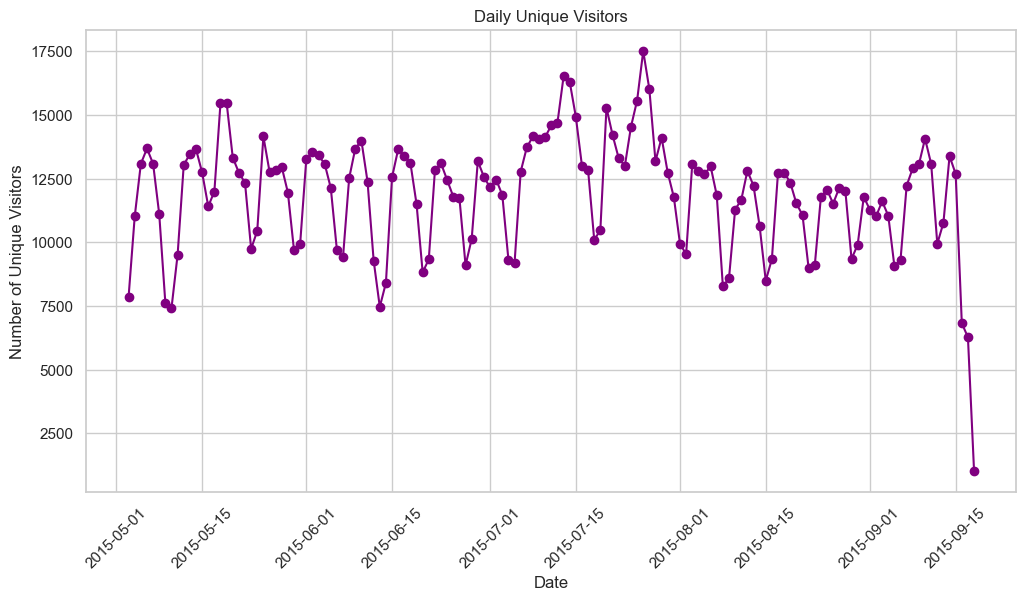

In [26]:
daily_visitors = df_events.groupby('date')['visitorid'].nunique()
plt.figure(figsize=(12,6))
plt.plot(daily_visitors.index, daily_visitors.values, color='purple', marker='o')
plt.title("Daily Unique Visitors")
plt.xlabel("Date")
plt.ylabel("Number of Unique Visitors")
plt.xticks(rotation=45)
plt.show()


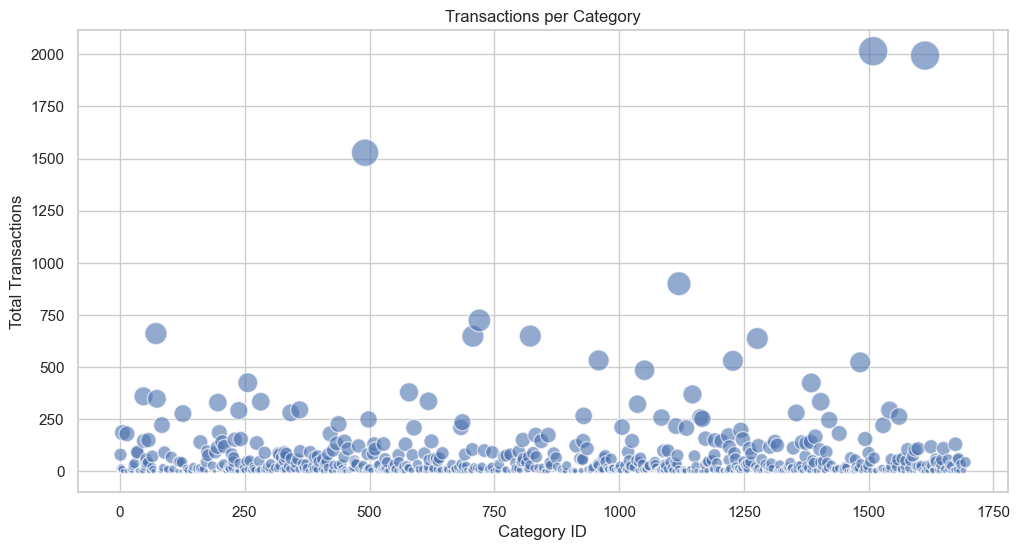

In [31]:
# Extract category property
category_data = df_properties[df_properties['property']=='categoryid'][['itemid','value']].copy()
category_data['categoryid'] = category_data['value'].astype(int)

# Count transactions per item
item_transactions = df_events[df_events['event']=='transaction'].groupby('itemid').size().reset_index(name='num_transactions')

# Merge transactions with category
cat_trans = pd.merge(item_transactions, category_data, on='itemid', how='inner')

# Aggregate transactions per category
cat_summary = cat_trans.groupby('categoryid')['num_transactions'].sum().reset_index()

# Bubble size proportional to number of transactions
bubble_sizes = np.sqrt(cat_summary['num_transactions']) * 10

# Plot
plt.figure(figsize=(12,6))
plt.scatter(
    cat_summary['categoryid'],
    cat_summary['num_transactions'],
    s=bubble_sizes,
    alpha=0.6,
    edgecolors='w'
)
plt.xlabel("Category ID")
plt.ylabel("Total Transactions")
plt.title("Transactions per Category")
plt.show()

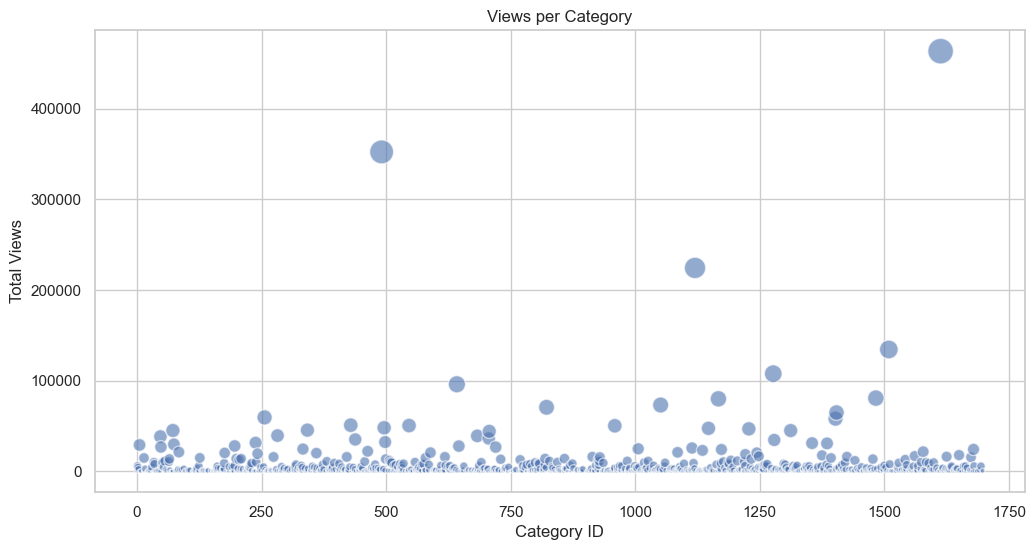

In [32]:
# Count views per item
item_views = df_events[df_events['event']=='view'].groupby('itemid').size().reset_index(name='num_views')

# Merge with category
cat_views = pd.merge(item_views, category_data, on='itemid', how='inner')

# Aggregate views per category
cat_views_summary = cat_views.groupby('categoryid')['num_views'].sum().reset_index()
bubble_sizes = np.sqrt(cat_views_summary['num_views']) * 0.5

# Plot
plt.figure(figsize=(12,6))
plt.scatter(
    cat_views_summary['categoryid'],
    cat_views_summary['num_views'],
    s=bubble_sizes,
    alpha=0.6,
    edgecolors='w'
)
plt.xlabel("Category ID")
plt.ylabel("Total Views")
plt.title("Views per Category")
plt.show()


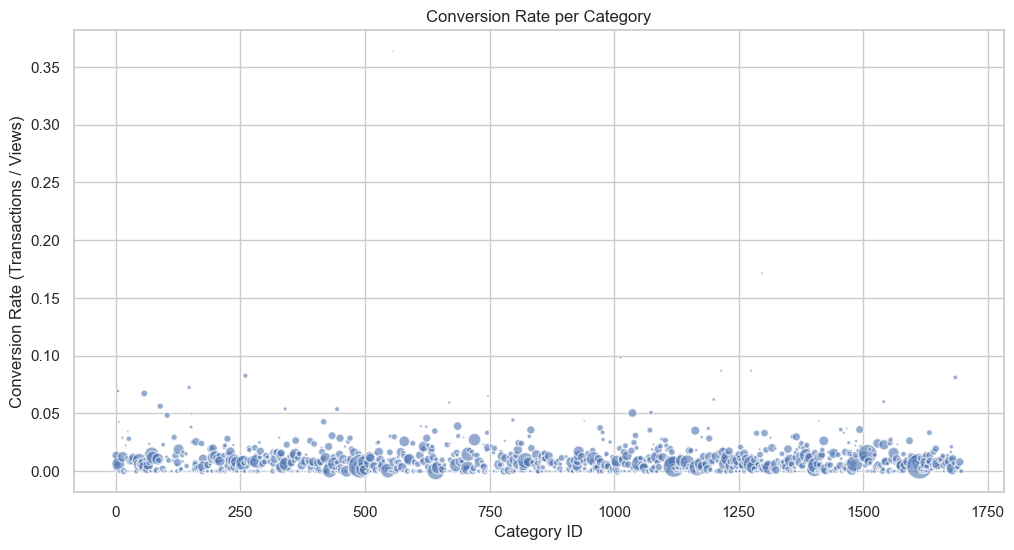

In [33]:
# Merge transactions and views per item
item_conv = pd.merge(item_views, item_transactions, on='itemid', how='left').fillna(0)
item_conv = pd.merge(item_conv, category_data, on='itemid', how='inner')

# Aggregate per category
cat_conv = item_conv.groupby('categoryid').agg({'num_views':'sum','num_transactions':'sum'}).reset_index()
cat_conv['conversion_rate'] = cat_conv['num_transactions'] / cat_conv['num_views']

# Bubble size proportional to total views
bubble_sizes = np.sqrt(cat_conv['num_views']) * 0.5

# Plot
plt.figure(figsize=(12,6))
plt.scatter(
    cat_conv['categoryid'],
    cat_conv['conversion_rate'],
    s=bubble_sizes,
    alpha=0.6,
    edgecolors='w'
)
plt.xlabel("Category ID")
plt.ylabel("Conversion Rate (Transactions / Views)")
plt.title("Conversion Rate per Category")
plt.show()


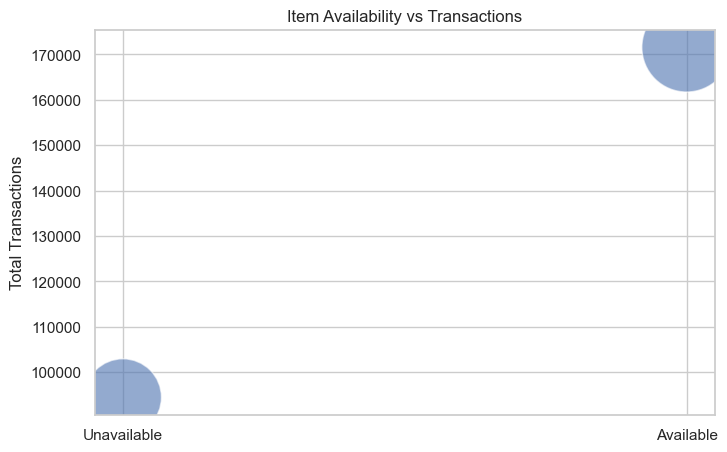

In [34]:
# Extract availability
availability = df_properties[df_properties['property']=='available'][['itemid','value']].copy()
availability['available'] = availability['value'].astype(int)

# Merge with transactions
avail_trans = pd.merge(item_transactions, availability, on='itemid', how='inner')

# Aggregate by availability
avail_summary = avail_trans.groupby('available')['num_transactions'].sum().reset_index()
bubble_sizes = np.sqrt(avail_summary['num_transactions'])*10

# Plot
plt.figure(figsize=(8,5))
plt.scatter(
    avail_summary['available'],
    avail_summary['num_transactions'],
    s=bubble_sizes,
    alpha=0.6,
    edgecolors='w'
)
plt.xticks([0,1],['Unavailable','Available'])
plt.ylabel("Total Transactions")
plt.title("Item Availability vs Transactions")
plt.show()
